In [1]:
import h5py
import matplotlib.pyplot as plt
from matplotlib import cm
import os

import numpy as np

In [26]:
# Paths
training_data_path = "2D_ConvAE_results/larger_dataset(interpolated)/ConvAE_trainingData_Gadi.txt"
testing_data1_path = "2D_ConvAE_results/larger_dataset(interpolated)/ConvAE_testingData_Gadi_1.txt"
testing_data2_path = "2D_ConvAE_results/larger_dataset(interpolated)/ConvAE_testingData_Gadi_2.txt"

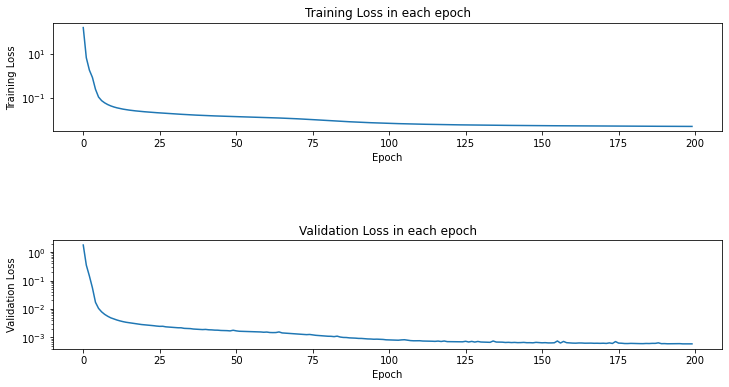

In [27]:
file1 = open(training_data_path, 'r')
Lines = file1.readlines()

training_data_list = []
for line in Lines:
    training_data_list.append([float(x) for x in line.strip().split('/')])
    
# Plot the Training loss and validation loss during training
plt.figure(figsize=(12, 6))
    
plt.subplot(2, 1, 1)
plt.plot(training_data_list[0])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss in each epoch')
plt.yscale("log")

plt.subplot(2, 1, 2)
plt.plot(training_data_list[1])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss in each epoch')
plt.yscale("log")
    
plt.subplots_adjust(hspace=1)
    
plt.show()

In [28]:
file1 = open(testing_data1_path, 'r')
Lines = file1.readlines()

testing_data_list1 = []
for line in Lines:
    testing_data_list1.append(line)
    
print("Total loss for the model on test set is",testing_data_list1[0])
#print("Accuracy for the model on test set is", testing_data_list1[1])

Total loss for the model on test set is 0.0006073427940123111



In [29]:
file2 = open(testing_data2_path, 'r')
Lines = file2.readlines()

best_worst_error_list = [float(x) for x in Lines[0].strip().split('/')]
best_worst_input_list = [np.asarray([float(y) for y in x.split('|')]).reshape(201,401) for x in Lines[1].strip().split('/')]
best_worst_predicted_list = [np.asarray([float(y) for y in x.split('|')]).reshape(201,401) for x in Lines[2].strip().split('/')]

Best model has a error of  1.3331761294921307e-07


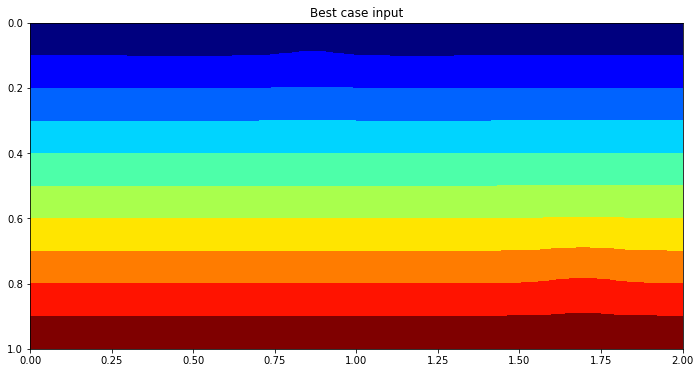

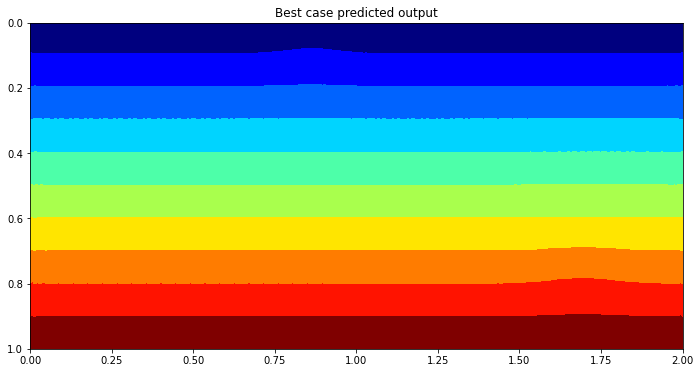

Worst model has a error of  3.187841139151715e-05


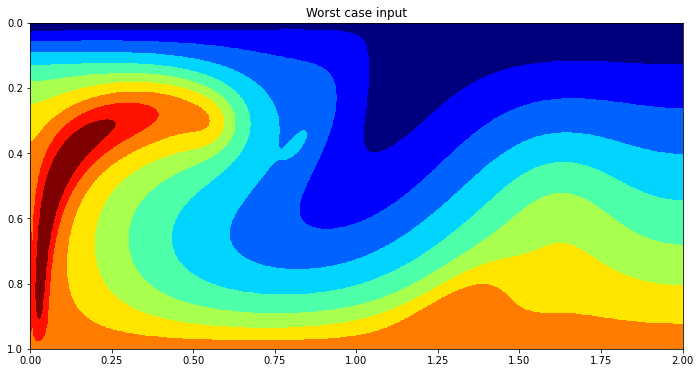

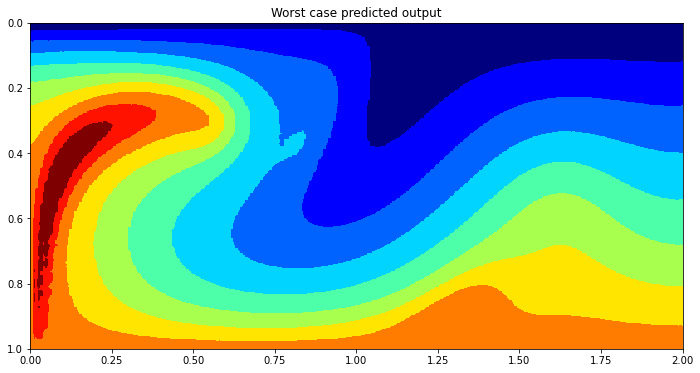

In [30]:
# Draw some plots for the best and the worst error
print("Best model has a error of ", best_worst_error_list[0])
    
plt.figure(figsize=(12, 6))
    
plt.title("Best case input")
    
plt.imshow(best_worst_input_list[0],
            cmap=cm.get_cmap('jet', 10),
            extent=(0, 2, 0, 1))

ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

    
plt.figure(figsize=(12, 6))
    
plt.title("Best case predicted output")
    
plt.imshow(best_worst_predicted_list[0],
            cmap=cm.get_cmap('jet', 10),
            extent=(0, 2, 0, 1))
   
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
        
plt.show()
    
    
print("Worst model has a error of ", best_worst_error_list[1])
    
plt.figure(figsize=(12, 6))
    
plt.title("Worst case input")
    
plt.imshow(best_worst_input_list[1],
            cmap=cm.get_cmap('jet', 10),
            extent=(0, 2, 0, 1))

ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()
    
    
plt.figure(figsize=(12, 6))
    
plt.title("Worst case predicted output")
    
plt.imshow(best_worst_predicted_list[1],
            cmap=cm.get_cmap('jet', 10),
            extent=(0, 2, 0, 1))
    

ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()